<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from math import log, exp, sqrt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

__1.1 Check shape and head of data.__

In [3]:
house.shape

(1460, 81)

In [4]:
# display all columns, display more rows

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


__1.2 Drop rows where MSZoning is non-residential (A,C or I)__

In [6]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
house = house[house['MSZoning'] != 'C (all)']
house.shape

(1450, 81)

__1.3 Drop ID column, drop columns with more than 40% null values__

In [8]:
# returns and drops list of columns with more than 40% null values

null_cols = house.columns[house.isnull().sum() > len(house)*0.4]
null_cols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [9]:
house.drop('Id', axis=1, inplace=True)
house.drop(null_cols, axis=1, inplace=True)

__1.4 Fill in null values__

In [10]:
# creates dataframe with columns with null values

isnull = pd.DataFrame(house.isnull().sum(), columns=['null_values']).reset_index()
isnull = isnull[isnull['null_values'] != 0]
isnull

,index,null_values
2,LotFrontage,259
23,MasVnrType,8
24,MasVnrArea,8
28,BsmtQual,37
29,BsmtCond,37
30,BsmtExposure,38
31,BsmtFinType1,37
33,BsmtFinType2,38
40,Electrical,1
55,GarageType,79


In [11]:
# fill numerical data with median, categorical data with mode

for col in isnull['index']:
    try:
        house[col].fillna(house[col].median(), inplace=True)
    except:
        house[col].fillna(house[col].mode()[0], inplace=True)
        
house.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

__1.5 Rename columns names with numbers as first characters__

In [12]:
unit_number = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 
           5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
new_col_names = []
for col in house.columns:
    if col[0] in [str(x) for x in range(10)]:
        new_col = unit_number[float(col[0])] + '_' + col[1:]
        new_col_names.append(new_col)
    else:
        new_col_names.append(col)
        
house.columns = new_col_names

__1.6 Identify and handle outliers__

In [13]:
house.describe(include='all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,one_stFlrSF,two_ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,three_SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1450.000000,1450,1450.000000,1450.000000,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450.000000,1450.000000,1450.000000,1450.000000,1450,1450,1450,1450,1450,1450.000000,1450,1450,1450,1450,1450,1450,1450,1450.000000,1450,1450.000000,1450.000000,1450.000000,1450,1450,1450,1450,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450,1450.000000,1450,1450.000000,1450,1450.000000,1450,1450.000000,1450.000000,1450,1450,1450,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450,1450,1450.000000
unique,NaN,4,NaN,NaN,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1446,916,1305,1449,1044,1375,225,1252,1436,1211,722,NaN,NaN,NaN,NaN,1135,1424,515,504,862,NaN,899,1275,647,676,1340,985,461,NaN,1284,NaN,NaN,NaN,1419,740,1361,1329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,727,NaN,1350,NaN,949,NaN,679,NaN,NaN,1382,1398,1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261,1194,NaN
mean,56.903448,NaN,70.043448,10523.831724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.114483,5.582069,1971.593103,1985.049655,NaN,NaN,NaN,NaN,NaN,103.828276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.162759,NaN,46.870345,567.375862,1059.408966,NaN,NaN,NaN,NaN,1164.773103,347.394483,5.531034,1517.698621,0.427586,0.057241,1.568966,0.384828,2.870345,1.046207,NaN,6.522069,NaN,0.616552,NaN,1978.702069,NaN,1.770345,473.277931,NaN,NaN,NaN,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,NaN,NaN,181654.942069
std,42.265033,NaN,22.022359,10012.185355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372860,1.107330,30.022696,20.552319,NaN,NaN,NaN,NaN,NaN,181.150114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.353871,NaN,161.828458,442.584978,439.207322,NaN,NaN,NaN,NaN,386.646095,437.094261,46.932966,525.154207,0.519394,0.238249,0.549549,0.503450,0.814645,0.219643,NaN,1.625324,NaN,0.644991,NaN,23.915011,NaN,0.745136,212.687621,NaN,NaN,NaN,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,NaN,NaN,79176.485241
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,1906.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,37900.000000
25%,20.000000,NaN,60.000000,7544.500000,NaN,NaN,NaN,NaN,NaN,NaN,N

In [14]:
# identify houses with 'LotArea' > or < 6 std away from mean

thres = 6 * house['LotArea'].std()
lotarea_mask = abs( house['LotArea'] - house['LotArea'].mean() ) > thres
house[lotarea_mask]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,one_stFlrSF,two_ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,three_SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,70.0,159000,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,0,6,2009,WD,Normal,375000
335,190,RL,70.0,164660,Grvl,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,700,8,2008,WD,Normal,228950
451,20,RL,62.0,70761,Pave,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,0,12,2006,WD,Normal,280000
706,20,RL,70.0,115149,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,0,6,2007,WD,Normal,302000


In [15]:
# create new column for big houses

house['big_house'] = 0
house.loc[lotarea_mask, 'big_house'] = 1
house['big_house'].value_counts()

0    1445
1       5
Name: big_house, dtype: int64

__1.7 Select relevant columns for analysis__

In [16]:
"""
Build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated
"""

# remove non-fixed variables (quality, condition, finishings) and other variables that can be changes such as: YearRemodAdd
# even though 'BsmtQual' is height of basement, we will take it as it is labelled - as a 'qual' variable
# 'BsmtExposure' will be a fixed variable as the exposure cannot be changed
# 'CentralAir' cannot be changed


non_fixed = ['OverallQual','OverallCond','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
             'MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinSF1',
             'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','Electrical','LowQualFinSF','KitchenQual',
             'Functional','GarageFinish','GarageQual','GarageCond','PavedDrive','MiscVal','SaleType','SaleCondition',
            'MoSold']

house_est = house.drop(non_fixed, axis=1)

In [17]:
house_est.shape

(1450, 44)

__1.8 EDA: explore relationships between saleprice and other variables__

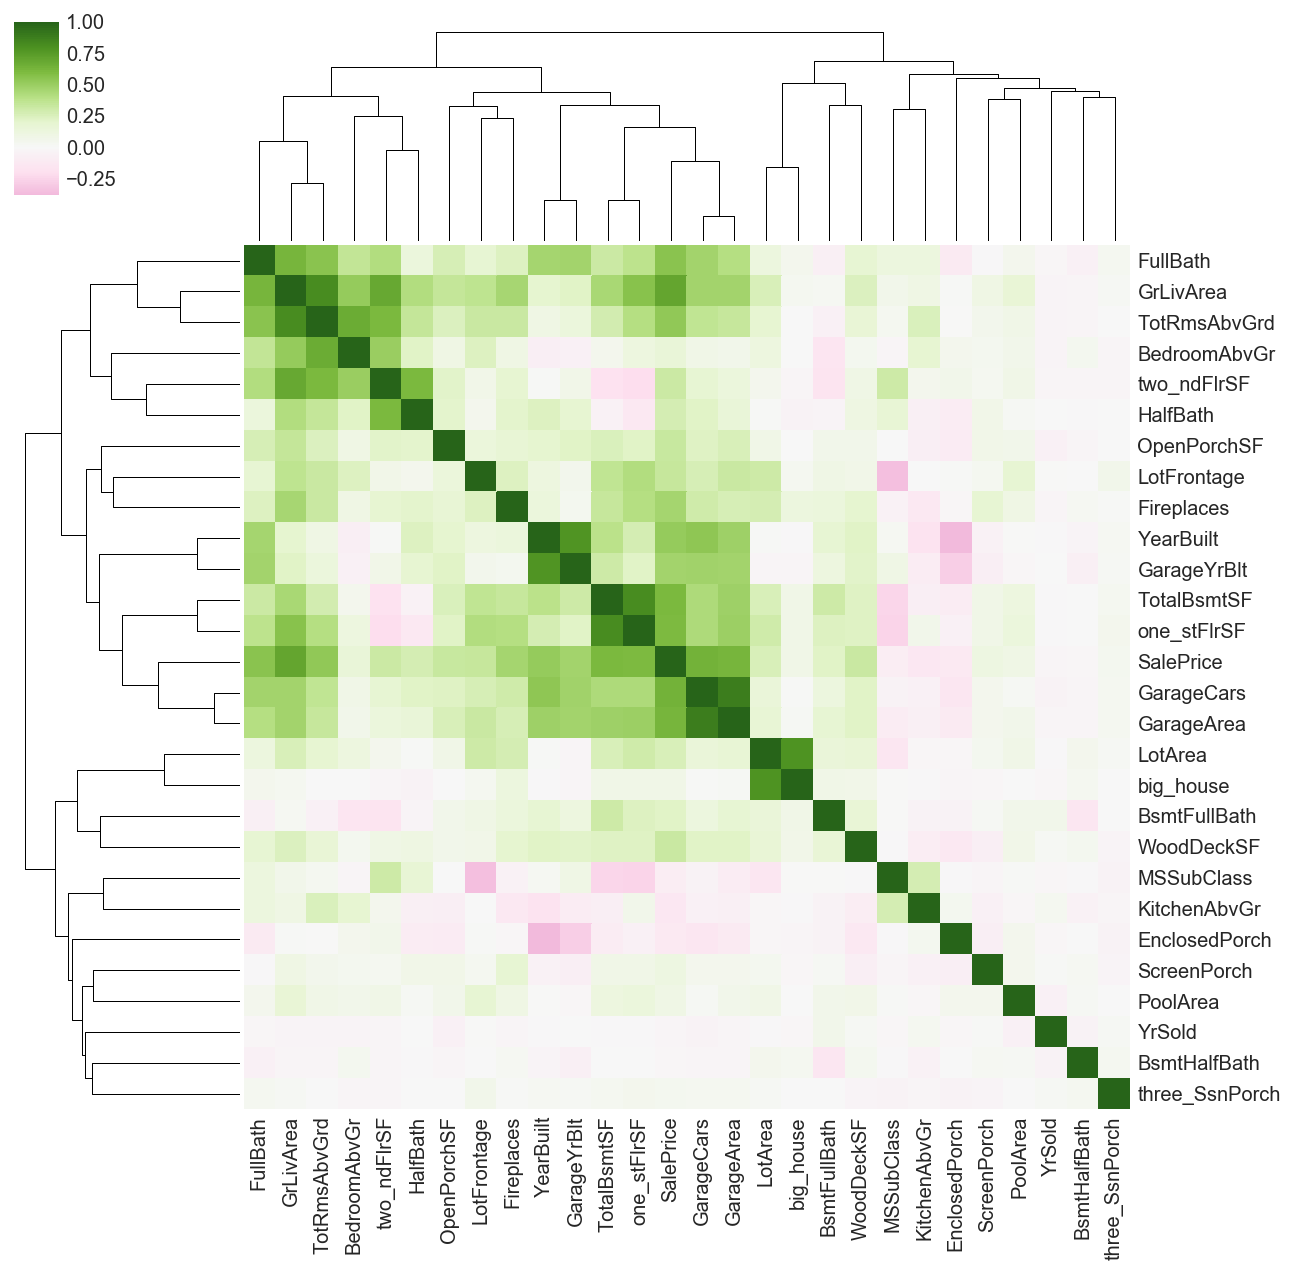

In [18]:
# numerical variables
# seems that saleprice and squarefeet and year built are more strongly correlated

plt.figure(figsize=(12,12))
sns.clustermap(house_est.corr(), cmap='PiYG', center=0)

In [19]:
abs(house_est.corr()['SalePrice']).sort_values(ascending=False).head(10)

SalePrice       1.000000
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
one_stFlrSF     0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
GarageYrBlt     0.467205
Name: SalePrice, dtype: float64

__1.9 Model: train-test-split, scale, fit, predict using Lasso__

In [20]:
def create_train_test_scale_fit(data, target):
    """Returns score, y_pred_lasso, y_test, X, coefs"""
    # create X, y
    f = f'{target} ~ '+' + '.join([c for c in data.columns])+' - 1'
    y, X = patsy.dmatrices(f, data=data, return_type='dataframe')
    
    # create train (before 2010) test (2010) split
    X_train = X[X['YrSold'] != 2010].drop([target,'YrSold'],axis=1)
    y_train = X[X['YrSold'] != 2010][target]

    X_test = X[X['YrSold'] == 2010].drop([target,'YrSold'],axis=1)
    y_test = X[X['YrSold'] == 2010][target]
    
    # scale
    ss = StandardScaler()
    ss.fit(X_train)
    Xs_train = ss.transform(X_train)
    Xs_test = ss.transform(X_test)

    # fit and score
    model_lasso = LassoCV(cv=10)
    model_lasso.fit(Xs_train, y_train)
    score = model_lasso.score(Xs_test, y_test)
    y_pred_lasso = model_lasso.predict(Xs_test)
    coefs = model_lasso.coef_
    
    return score, y_pred_lasso, y_test, X, coefs

In [21]:
score, y_pred_lasso, y_test, X, coefs = create_train_test_scale_fit(house_est, target='SalePrice')

In [22]:
score

0.85872275114902352

__1.10 Plot residuals__

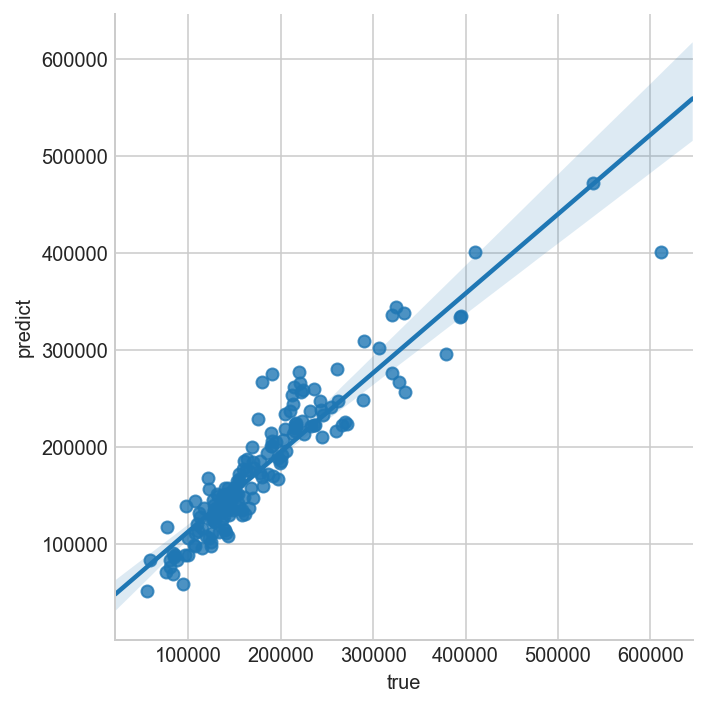

In [23]:
residual_plot = pd.DataFrame(list(zip(y_pred_lasso,y_test)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

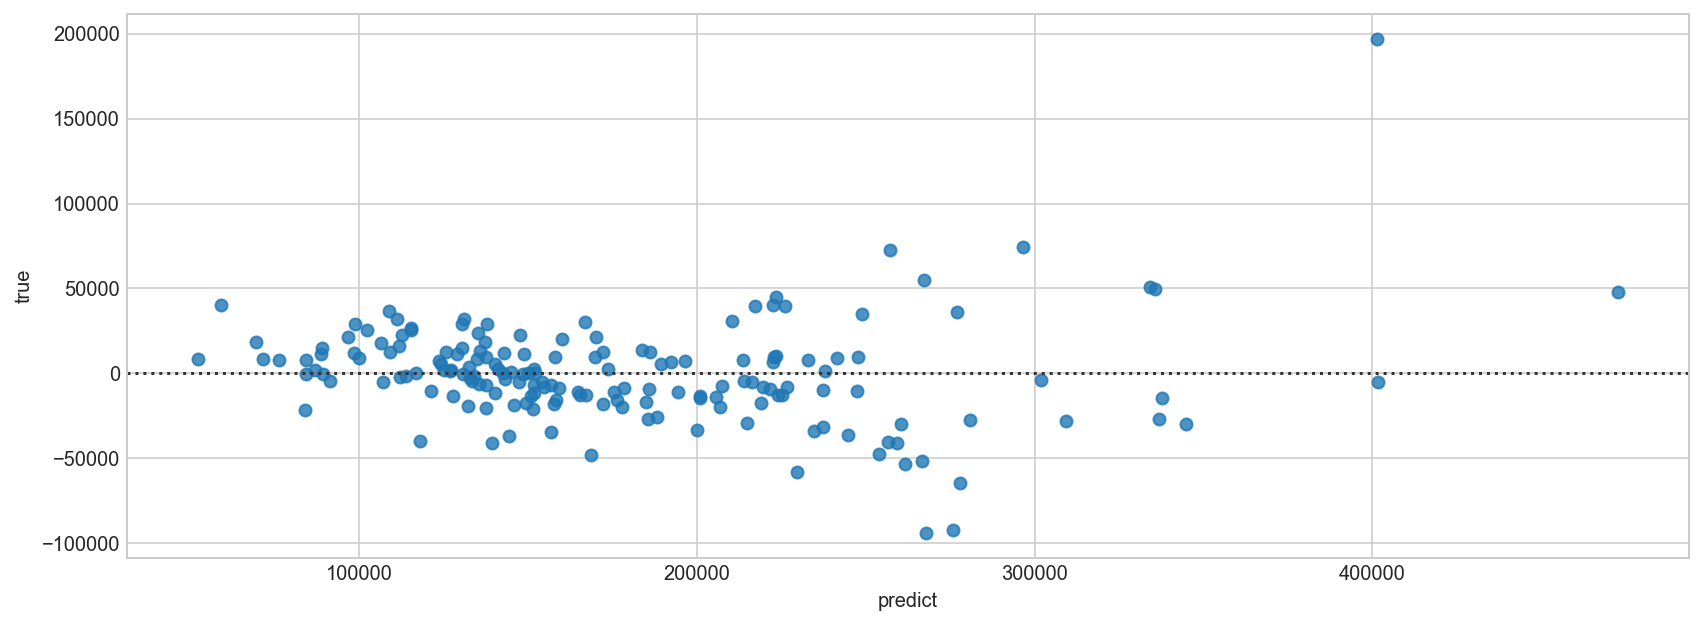

In [24]:
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

Residuals are not randomly scattered around. The residuals fan out as the prices increase, suggesting linear regression is not appropriate.

__1.11 Try to log SalePrice__

In [25]:
# add the log of the saleprice as a new column and drop the original saleprice
house['SalePrice_lg'] = house['SalePrice'].map(log)
non_fixed.append('SalePrice')
house_est_2 = house.drop(non_fixed, axis=1)

In [26]:
# run the model against the log saleprice
score_log, y_pred_lasso_log, y_test_log, X_log, coefs_log = create_train_test_scale_fit(house_est_2, target='SalePrice_lg')

In [27]:
score_log

0.89344936925335205

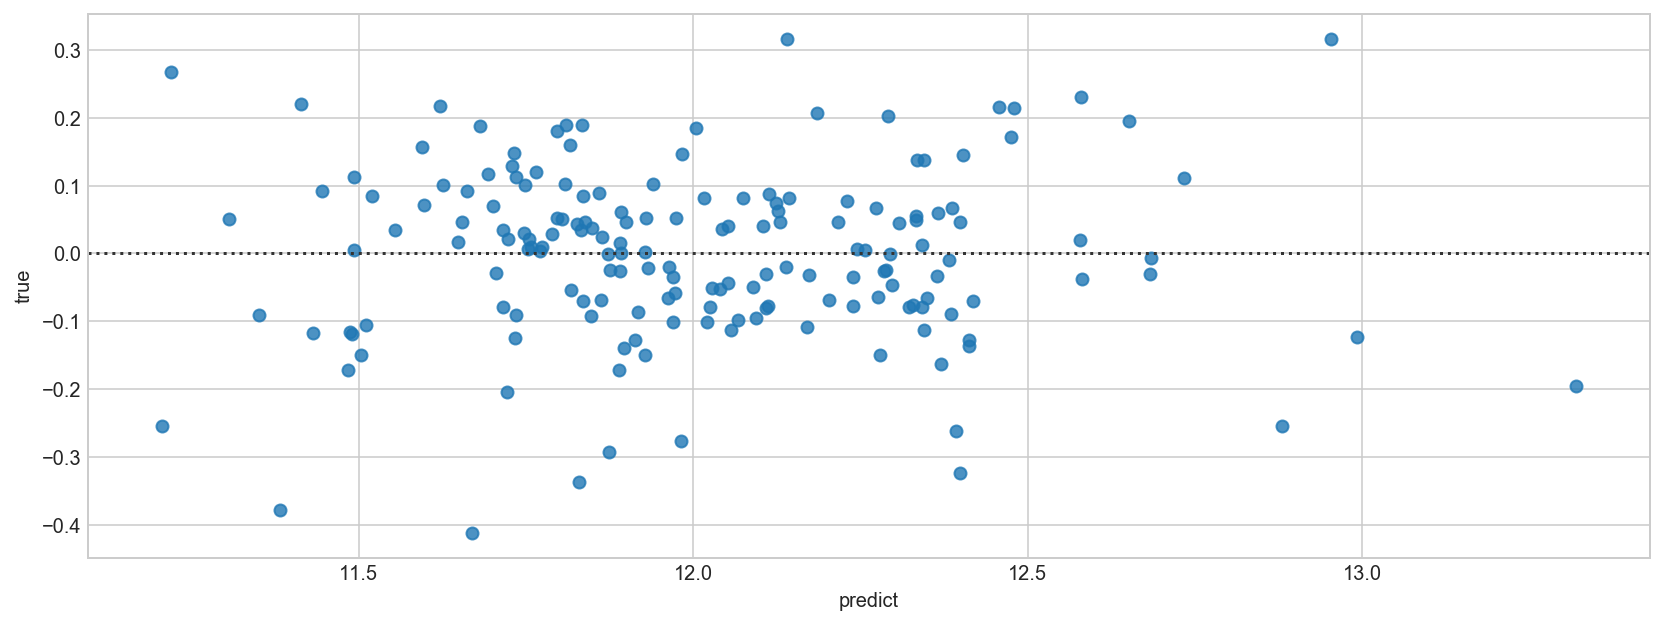

In [28]:
residual_plot = pd.DataFrame(list(zip(y_pred_lasso_log,y_test_log)), columns=['predict','true'])
plt.figure(figsize=(14,5))
sns.residplot(x='predict', y='true', data=residual_plot)

__1.12 Check top coefficients__

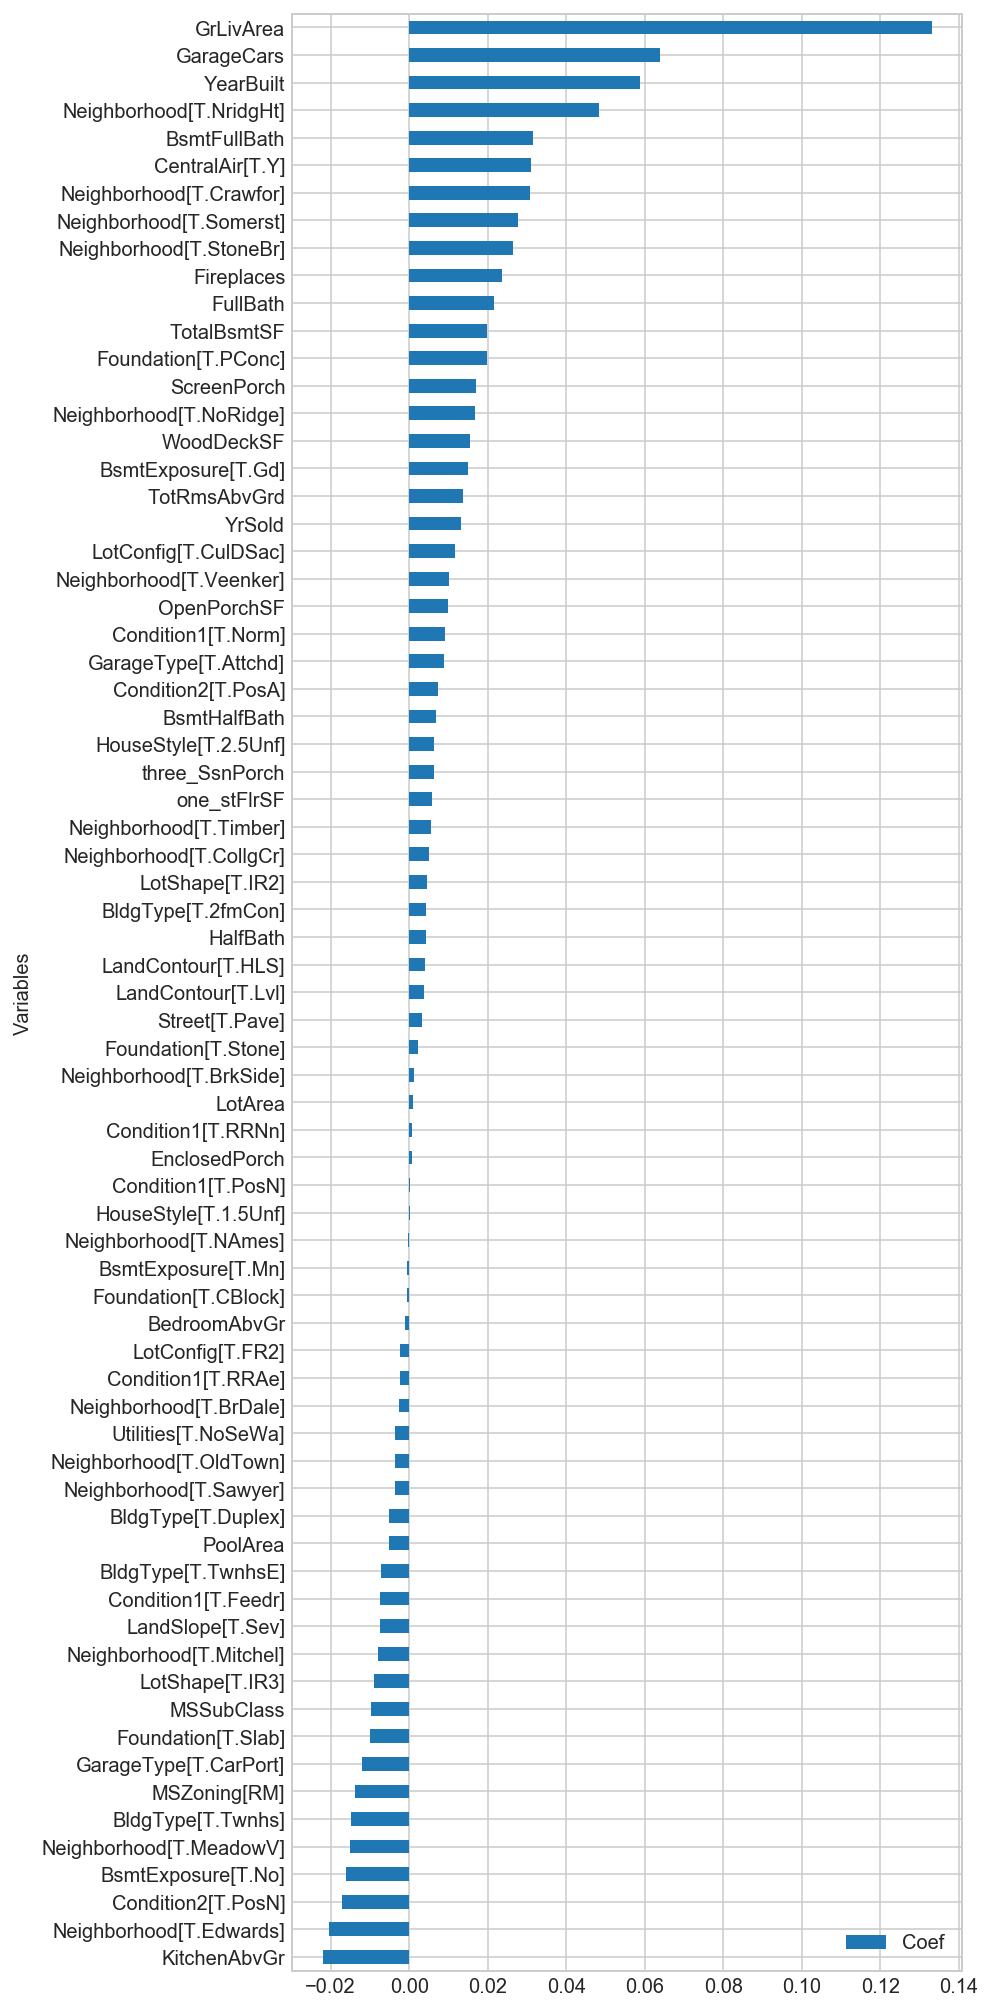

In [29]:
lasso_coefs = pd.DataFrame(list(zip(X_log.columns, coefs_log)), columns=['Variables','Coef'])
lasso_coefs = lasso_coefs.loc[(lasso_coefs['Coef'] != 0)]
lasso_coefs.sort_values('Coef', ascending=True).plot(x='Variables',y='Coef',figsize=(6,18), kind='barh')

In [30]:
lasso_coefs['Coef_abs'] = lasso_coefs['Coef'].abs()
lasso_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs
89,GrLivArea,0.133019,0.133019
99,GarageCars,0.063969,0.063969
85,YearBuilt,0.058892,0.058892
33,Neighborhood[T.NridgHt],0.048256,0.048256
90,BsmtFullBath,0.031506,0.031506
76,CentralAir[T.Y],0.031098,0.031098
23,Neighborhood[T.Crawfor],0.030769,0.030769
38,Neighborhood[T.Somerst],0.027612,0.027612
39,Neighborhood[T.StoneBr],0.026359,0.026359
97,Fireplaces,0.023513,0.023513


__Top estimators of price__
- GrLivArea: Above grade (ground) living area square feet
- GarageCars: Size of garage in car capacity
- YearBuilt: Original construction date
- Neighbourhood: NridgHt

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

__2.1 Evaluate residual from fixed-variable-model__

In [31]:
residual_plot['predict_value'] = residual_plot['predict'].map(exp)
residual_plot['true_value'] = residual_plot['true'].map(exp)
residual_plot['residual'] = abs(residual_plot['true_value'] - residual_plot['predict_value'])
residual_plot.head()

,predict,true,predict_value,true_value,residual
0,11.931665,11.911702,152004.452512,149000.0,3004.452512
1,11.899528,11.944708,147197.161356,154000.0,6802.838644
2,11.789101,11.811547,131807.925637,134800.0,2992.074363
3,12.577665,12.631340,290008.316137,306000.0,15991.683863
4,12.052488,12.016726,171525.588687,165500.0,6025.588687


In [32]:
fixed_var_residual_mean = residual_plot['residual'].mean()
fixed_var_residual_median = residual_plot['residual'].median()

In [33]:
residual_plot['residual'].describe()

count       172.000000
mean      17796.600363
std       21634.871352
min          25.243243
25%        6086.933539
50%       12356.191530
75%       19430.250972
max      189240.779282
Name: residual, dtype: float64

__2.2 EDA for model with changeable features__

In [34]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'one_stFlrSF', 'two_ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPo

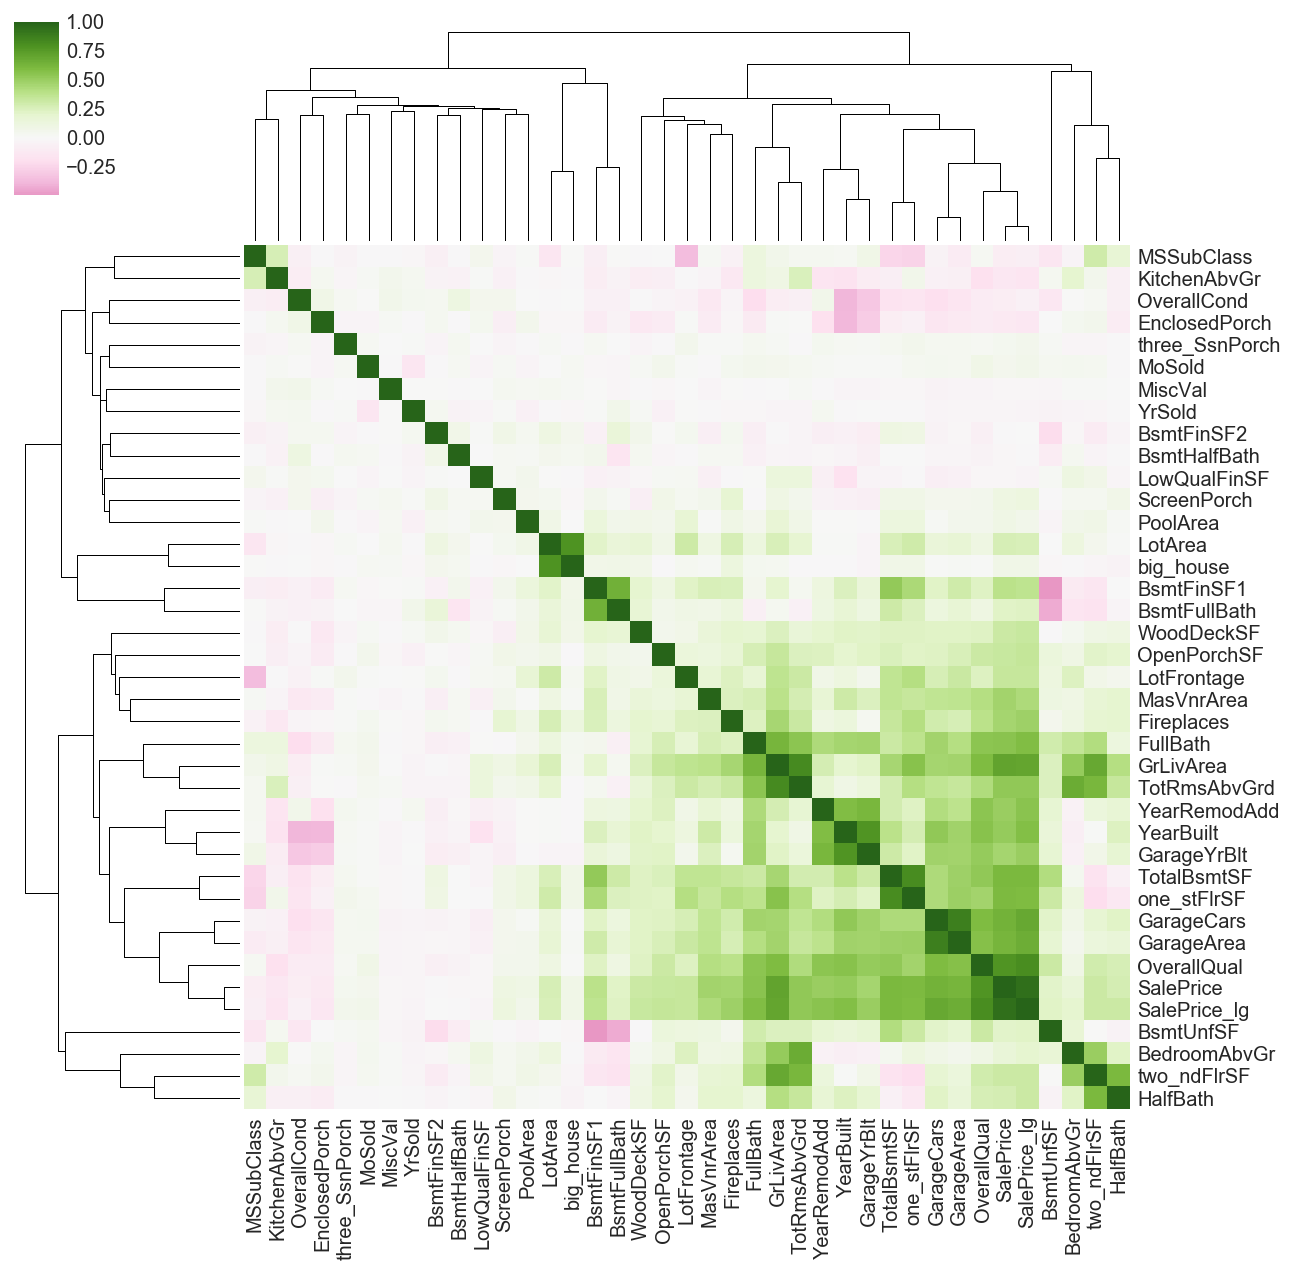

In [35]:
plt.figure(figsize=(12,12))
sns.clustermap(house.corr(), cmap='PiYG', center=0)

In [36]:
abs(house.corr()['SalePrice']).sort_values(ascending=False).head(10)

SalePrice       1.000000
SalePrice_lg    0.952050
OverallQual     0.789031
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
one_stFlrSF     0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
Name: SalePrice, dtype: float64

In [37]:
house_lg = house.drop('SalePrice', axis=1)

In [38]:
# use log of SalePrice as target
score_lg, y_pred_lasso_lg, y_test_lg, X_lg, coefs_lg = create_train_test_scale_fit(house_lg, 'SalePrice_lg')

In [39]:
score_lg

0.90977009991384072

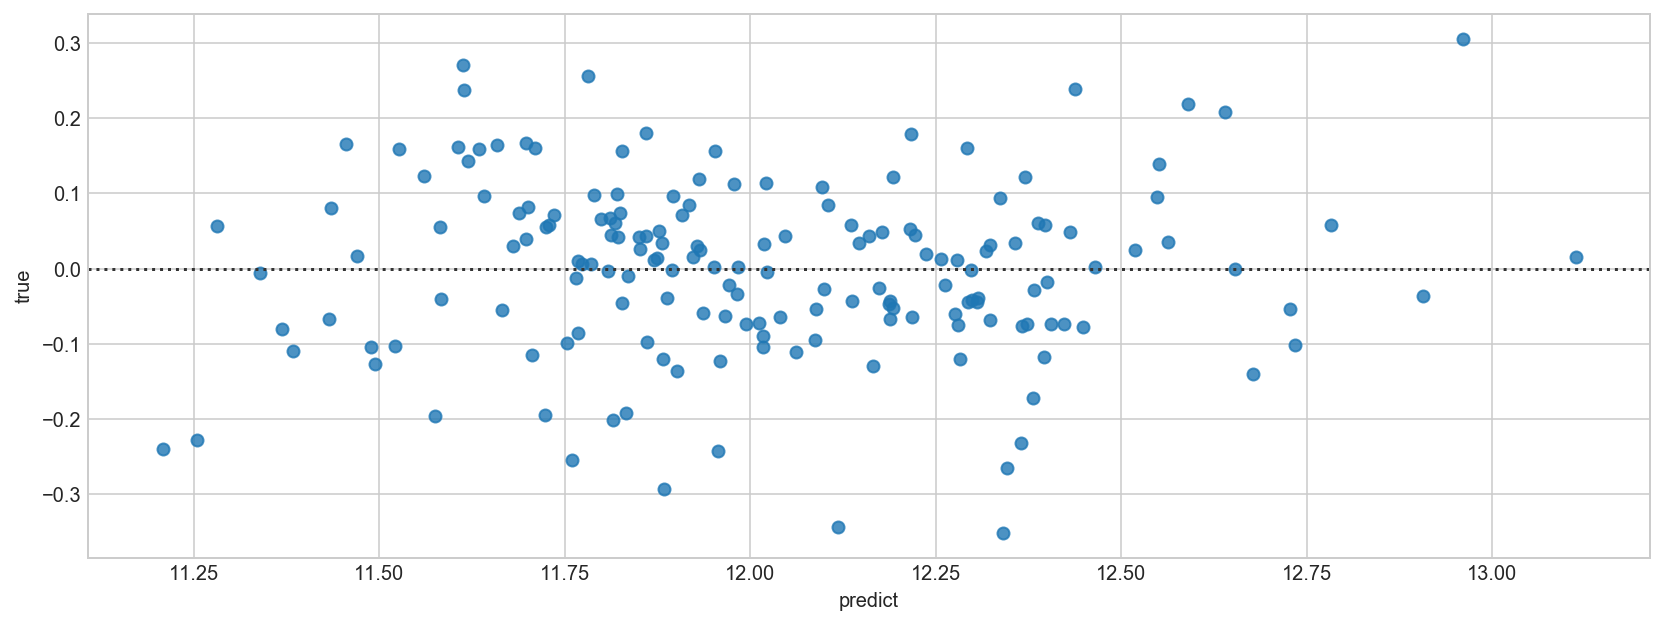

In [40]:
residual_plot = pd.DataFrame(list(zip(y_pred_lasso_lg, y_test_lg)), columns=['predict','true'])
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

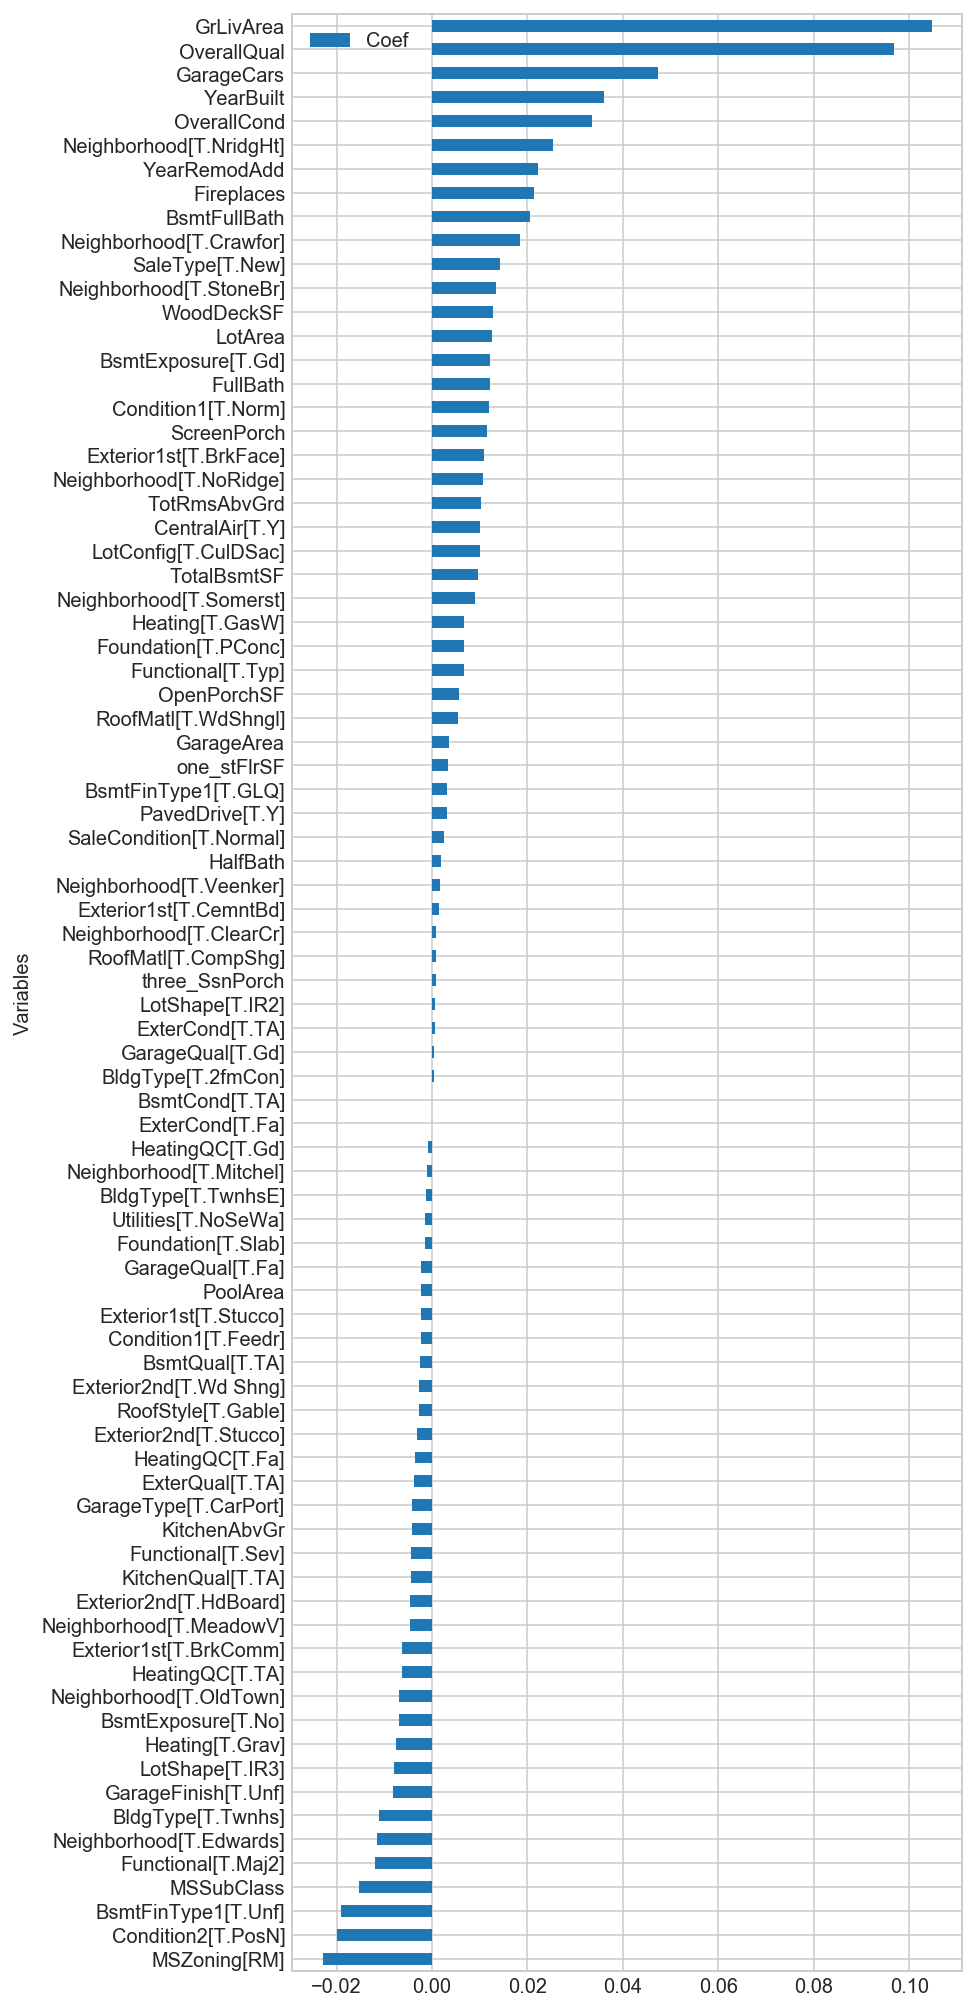

In [41]:
lasso_coefs = pd.DataFrame(list(zip(X_lg.columns, coefs_lg)), columns=['Variables','Coef'])
lasso_coefs = lasso_coefs.loc[(lasso_coefs['Coef'] != 0)]
lasso_coefs.sort_values('Coef', ascending=True).plot(x='Variables',y='Coef',figsize=(6,18), kind='barh')

In [42]:
lasso_coefs['Coef_abs'] = lasso_coefs['Coef'].abs()
lasso_coefs['Coef_true'] = lasso_coefs['Coef'].map(lambda x: exp(x**2))
lasso_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs,Coef_true
211,GrLivArea,0.104663,0.104663,1.011014
199,OverallQual,0.096880,0.096880,1.009430
221,GarageCars,0.047423,0.047423,1.002252
201,YearBuilt,0.035963,0.035963,1.001294
200,OverallCond,0.033577,0.033577,1.001128
33,Neighborhood[T.NridgHt],0.025402,0.025402,1.000645
3,MSZoning[RM],-0.022880,0.022880,1.000524
202,YearRemodAdd,0.022110,0.022110,1.000489
219,Fireplaces,0.021323,0.021323,1.000455
212,BsmtFullBath,0.020551,0.020551,1.000422


__Top estimators of price__
- GrLivArea: Above grade (ground) living area square feet
- OverallQual
- GarageCars: Size of garage in car capacity
- YearBuilt: Original construction date
- OverallCond

__2.4 Evaluate residuals__

In [43]:
# find out the difference in predicted and actual values
residual_plot['predict_value'] = residual_plot['predict'].map(lambda x: exp(x))
residual_plot['true_value'] = residual_plot['true'].map(lambda x: exp(x))
residual_plot['residual'] = abs(residual_plot['true_value'] - residual_plot['predict_value'])
residual_plot.head()

,predict,true,predict_value,true_value,residual
0,12.017885,11.911702,165691.845329,149000.0,16691.845329
1,11.971660,11.944708,158207.054898,154000.0,4207.054898
2,11.835027,11.811547,138002.436918,134800.0,3202.436918
3,12.562571,12.631340,285663.859970,306000.0,20336.140030
4,12.022123,12.016726,166395.548481,165500.0,895.548481


In [44]:
# after sorting, we see that the greatest difference goes up to 18.6k!
residual_plot.sort_values('residual', ascending=False).head(10)

,predict,true,predict_value,true_value,residual
109,12.960369,13.323927,425222.975254,611657.0,186434.024746
55,12.639695,12.885202,308567.170169,394432.0,85864.829831
145,12.590158,12.843971,293654.256159,378500.0,84845.743841
125,12.437183,12.700769,251999.762683,328000.0,76000.237317
138,12.340238,12.007622,228716.362374,164000.0,64716.362374
85,12.117945,11.779129,183128.836078,130500.0,52628.836078
152,12.551269,12.721886,282453.321379,335000.0,52546.678621
9,12.346789,12.100712,230219.731466,180000.0,50219.731466
154,12.365680,12.154779,234610.078535,190000.0,44610.078535
93,13.112506,13.195614,495095.596545,538000.0,42904.403455


In [45]:
all_var_residual_mean = residual_plot['residual'].mean()
all_var_residual_median = residual_plot['residual'].median()

In [46]:
residual_plot['residual'].describe()

count       172.000000
mean      16062.543783
std       19720.096906
min         139.597745
25%        5813.109980
50%       11760.871342
75%       18897.451312
max      186434.024746
Name: residual, dtype: float64

In [47]:
print(f"mean diff: {fixed_var_residual_mean} - {all_var_residual_mean} = {fixed_var_residual_mean - all_var_residual_mean}")
print(f"median diff: {fixed_var_residual_median} - {all_var_residual_median} = {fixed_var_residual_median - all_var_residual_median}")

mean diff: 17796.60036258975 - 16062.54378254997 = 1734.0565800397799
median diff: 12356.191530466487 - 11760.871341635837 = 595.3201888306503


__The effect in dollars of adding the renovate-able features:__ 
The predicted price is \$1734 closer to the true sale price of the property, if we take the mean as average. 
However if we take the median, we only get $595 closer to the true value by adding the renovatable features!

__How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.__

The company should use the second model to predict the potential buy and sale price of the property.

They can also assess how much they should spend on renovating.
For example, increasing the OverallQual value by 1 point increases the price of the property by 0.02%.
In order to make money, they should not spend more than 0.02% of the price of the property on renovating to increase OverallQual by 1 point.

For the company to make money, the cost of 'flipping' the house (renovating, time and effort to buy and sell the houses, and risk taken on) has to be less than the potential increase in price of the property.

__Investigate how much of the variance in price remaining is explained by these features.__

Model 1 R^2: 0.893
Model 2 R^2: 0.909

These features explain 1.6% more of the variance, on top of model 1.

__Do you trust your model? Should it be used to evaluate which properties to buy and fix up?__

As the predicted price can be different from the actual price, I want assess the actual potential of actually earning money after factoring in the error in prediction.

As a conservative estimate, I would prefer to buffer for up to 75\% percentile of the residuals (this gives an error of \$19,000 in my predicted price) - which is around 11.5\% of the median sale price of a property ($164,000).

Given the difficulty in increasing the price of the property, the error rate of the model seems too high. For example, an increase in one point of OverallQual only increases price by 0.02\% (which is less than \$50!). I would not take a risk of $19,000 given the difficulty of increasing the price of the property after renovation.

I would not use this model to evaluate which properties to buy and fix up.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

__3.1 Train test split (test on 2010) and scale__

In [48]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,one_stFlrSF,two_ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,three_SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,big_house,SalePrice_lg
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,0,12.247694
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0,12.109011
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,0,12.317167
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,0,11.849398
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,0,12.429216


In [49]:
f = 'SaleCondition + YrSold ~ '+' + '.join([c for c in house.columns if c != 'SaleCondition'])+' - 1'
f

'SaleCondition + YrSold ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + OverallQual + OverallCond + YearBuilt + YearRemodAdd + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Heating + HeatingQC + CentralAir + Electrical + one_stFlrSF + two_ndFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + GarageType + GarageYrBlt + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + three_SsnPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold + SaleType + SalePrice + big_house + SalePric

In [50]:
y, X = patsy.dmatrices(f, data=house, return_type='dataframe')

In [51]:
# create train test split
X_train = X[X['YrSold'] != 2010].drop(['YrSold'],axis=1)
y_train = y[y['YrSold'] != 2010]['SaleCondition[Abnorml]']

X_test = X[X['YrSold'] == 2010].drop(['YrSold'],axis=1)
y_test = y[y['YrSold'] == 2010]['SaleCondition[Abnorml]']

In [52]:
# scale
ss = StandardScaler()
ss.fit(X_train)
Xs_train = ss.transform(X_train)
Xs_test = ss.transform(X_test)

In [53]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, make_scorer

# empty list to hold all model scores
overall_scores = []

# make precision scorer
scorer = make_scorer(f1_score)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


__3.2 Try with weights__

In [54]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [57]:
# map class weights to each y value
class_weight = y_train.map(lambda x: class_weight[0] if x == 0 else class_weight[1])
len(class_weight)

1278

In [58]:
from sklearn.linear_model import LogisticRegressionCV

# define model and fit
lg = LogisticRegressionCV(Cs=50, cv=5, scoring=scorer, penalty='l2')
lg.fit(Xs_train, y_train, sample_weight=class_weight)
    
# obtain mean of cross validation precision scores
avg_score = np.mean(list(lg.scores_.values()))
    
# obtain cross validation predictions to make classification report and confusion matrix
y_pred_lg = lg.predict(Xs_test)

# find coefs
coefs = pd.DataFrame(list(zip(X_train.columns, lg.coef_[0])), columns=['Variable','Coef'])
coefs = coefs.loc[(coefs['Coef'] != 0)]
coefs['Coef_abs'] = coefs['Coef'].abs()
top_3_coefs = coefs.sort_values('Coef_abs', ascending=False).head(3)
    
# print scores    
print(f"""
Logistic Regression - with weights
-------------------------------------------------------------

{metrics.classification_report(y_test, y_pred_lg)}

{metrics.confusion_matrix(y_test, y_pred_lg)}

Average f-1 score from CV: {avg_score}

top 3 coefficients: 
{top_3_coefs}


""")

# append to overall scores
overall_scores.append((avg_score, f"Logistic Regression - with weights"))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression - with weights
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       163
        1.0       0.25      0.11      0.15         9

avg / total       0.92      0.94      0.92       172


[[160   3]
 [  8   1]]

Average f-1 score from CV: 0.14019838945899732

top 3 coefficients: 
            Variable      Coef  Coef_abs
188  SaleType[T.New] -1.304905  1.304905
228     SalePrice_lg -1.132948  1.132948
190   SaleType[T.WD] -0.976516  0.976516





__3.3 Revise datasets with undersampling/oversampling/SMOTE/SMOTEENN__

In [59]:
# undersampling

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled_under, y_resampled_under = cc.fit_sample(Xs_train, y_train)

# oversampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled_over, y_resampled_over = ros.fit_sample(Xs_train, y_train)

# SMOTE

from imblearn.over_sampling import SMOTE
X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(Xs_train, y_train)

# SMOTEENN

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_sample(Xs_train, y_train)

__3.4 Logistic Regression with cross validation__

In [60]:
def model_lg(technique, X_resampled, y_resampled, Xs_test, y_test):

    # define model and fit
    lg = LogisticRegressionCV(Cs=50, cv=5, scoring=scorer, penalty='l2')
    lg.fit(X_resampled, y_resampled)
    
    # obtain mean of cross validation precision scores
    avg_score = np.mean(list(lg.scores_.values()))
    
    # obtain cross validation predictions to make classification report and confusion matrix
    y_pred_lg = lg.predict(Xs_test)

    # find coefs
    coefs = pd.DataFrame(list(zip(X_train.columns, lg.coef_[0])), columns=['Variable','Coef'])
    coefs = coefs.loc[(coefs['Coef'] != 0)]
    coefs['Coef_abs'] = coefs['Coef'].abs()
    top_3_coefs = coefs.sort_values('Coef_abs', ascending=False).head(3)
    
    # print scores    
    print(f"""
{technique}
-------------------------------------------------------------

{metrics.classification_report(y_test, y_pred_lg)}

{metrics.confusion_matrix(y_test, y_pred_lg)}

Average f-1 score from CV: {avg_score}

top 3 coefficients: 
{top_3_coefs}


""")
    
    # append to overall scores
    overall_scores.append((avg_score, f"Logistic Regression - {technique}"))


In [61]:
model_lg('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_lg('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_lg('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_lg('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)


undersampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       1.00      0.31      0.48       163
        1.0       0.07      1.00      0.14         9

avg / total       0.95      0.35      0.46       172


[[ 51 112]
 [  0   9]]

Average f-1 score from CV: 0.525048854388853

top 3 coefficients: 
               Variable      Coef  Coef_abs
189     SaleType[T.Oth]  0.002942  0.002942
51   Condition2[T.Norm]  0.002849  0.002849
143     Heating[T.GasA]  0.002610  0.002610




oversampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.95      0.86      0.90       163
        1.0       0.08      0.22      0.12         9

avg / total       0.91      0.83      0.86       172


[[140  23]
 [  7   2]]

Average f-1 score from CV: 0.876412765006464

top 3 coefficients: 
               Variable       Coef   Coef_abs
191   

__3.5 Decision tree classifier__

In [62]:
from sklearn.tree import DecisionTreeClassifier

def model_tree(technique, X_resampled, y_resampled, Xs_test, y_test):
    # run cross validation
    tree = DecisionTreeClassifier()
    scores = cross_val_score(tree, X_resampled, y_resampled, cv=5, scoring=scorer)
    
    # obtain avg cross validated precision score
    avg_score = scores.mean()

    # run tree for predictions to make classification report and confusion matrix
    tree.fit(X_resampled, y_resampled)
    y_pred_tree = tree.predict(Xs_test)
    
    # print scores
    print(f"""
{technique}
-------------------------------------------------------------

{metrics.classification_report(y_test, y_pred_tree)}

{metrics.confusion_matrix(y_test, y_pred_tree)}

average f-1 score from CV: {avg_score}

""")
    
    # append to overall scores
    overall_scores.append((avg_score, f"Decision Tree - {technique}"))
    
model_tree('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_tree('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_tree('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_tree('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)


undersampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.97      0.17      0.29       163
        1.0       0.06      0.89      0.11         9

avg / total       0.92      0.21      0.28       172


[[ 28 135]
 [  1   8]]

average f-1 score from CV: 0.7488416988416988



oversampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97       163
        1.0       0.33      0.11      0.17         9

avg / total       0.92      0.94      0.93       172


[[161   2]
 [  8   1]]

average f-1 score from CV: 0.9672476346025173



SMOTE
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.93      0.94       163
        1.0       0.15      0.22      0.18         9

avg / total       0.91      0.90      

__3.6 KNN__

In [63]:
from sklearn.neighbors import KNeighborsClassifier


def model_knn(technique, X_resampled, y_resampled, Xs_test, y_test):
    
    cv_scores = []

    # create list of odd numbers for cross-validation
    neighbors = list(range(1,15,2))

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_resampled, y_resampled, cv=5, scoring=scorer)
        cv_scores.append((scores.mean(), k))

    #obtain best k and best mean cv f-beta score
    best_k = max(cv_scores)[1]
    avg_score = max(cv_scores)[0]

    # run KNN on best_k for predictions to make classification report and confusion matrix
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_resampled, y_resampled)
    y_pred_knn = knn.predict(Xs_test)
    
    # print scores
    print(f"""
{technique}
n_neighbours = {best_k}
-------------------------------------------------------------

{metrics.classification_report(y_test, y_pred_knn)}

{metrics.confusion_matrix(y_test, y_pred_knn)}

average f-1 score from CV: {avg_score}

""")
    
    # append to overall scores
    overall_scores.append((avg_score, f"KNN - {technique}"))
    return avg_score
    
model_knn('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_knn('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_knn('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_knn('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)


undersampling
n_neighbours = 3
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.95      0.93      0.94       163
        1.0       0.08      0.11      0.09         9

avg / total       0.90      0.88      0.89       172


[[151  12]
 [  8   1]]

average f-1 score from CV: 0.29619047619047617




/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco


oversampling
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.92      0.94       163
        1.0       0.13      0.22      0.17         9

avg / total       0.91      0.88      0.90       172


[[150  13]
 [  7   2]]

average f-1 score from CV: 0.9555061306418178



SMOTE
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.95      0.83      0.89       163
        1.0       0.07      0.22      0.10         9

avg / total       0.90      0.80      0.84       172


[[135  28]
 [  7   2]]

average f-1 score from CV: 0.9044683166308352



SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13    

0.98271528274536624

__3.7 SVM__

In [64]:
from sklearn.svm import SVC

def model_svc(technique, X_resampled, y_resampled, Xs_test, y_test):
    # run cross validation
    svc = SVC()
    scores = cross_val_score(svc, X_resampled, y_resampled, cv=5, scoring=scorer)
    
    # obtain avg cross validated precision score
    avg_score = scores.mean()

    # run tree for predictions to make classification report and confusion matrix
    svc.fit(X_resampled, y_resampled)
    y_pred_svc = svc.predict(Xs_test)
    
    # print scores
    print(f"""
{technique}
-------------------------------------------------------------

{metrics.classification_report(y_test, y_pred_svc)}

{metrics.confusion_matrix(y_test, y_pred_svc)}

average f-1 score from CV: {avg_score}

""")
    
    # append to overall scores
    overall_scores.append((avg_score, f"SVM - {technique}"))
    return avg_score
    
model_svc('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_svc('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_svc('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_svc('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)


undersampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.98      0.59      0.74       163
        1.0       0.09      0.78      0.17         9

avg / total       0.93      0.60      0.71       172


[[96 67]
 [ 2  7]]

average f-1 score from CV: 0.5285640573267348



oversampling
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96       163
        1.0       0.25      0.22      0.24         9

avg / total       0.92      0.92      0.92       172


[[157   6]
 [  7   2]]

average f-1 score from CV: 0.9526348943339933



SMOTE
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.92      0.94       163
        1.0       0.13      0.22      0.17         9

avg / total       0.91      0.88      0.90

0.97830100922439267

In [65]:
list(reversed(sorted(overall_scores)))

[(0.98271528274536624, 'KNN - SMOTEENN'),
 (0.97830100922439267, 'SVM - SMOTEENN'),
 (0.96724763460251728, 'Decision Tree - oversampling'),
 (0.95550613064181777, 'KNN - oversampling'),
 (0.95263489433399329, 'SVM - oversampling'),
 (0.95220455600213505, 'SVM - SMOTE'),
 (0.93894419901634607, 'Decision Tree - SMOTEENN'),
 (0.9372403652231821, 'Logistic Regression - SMOTEENN'),
 (0.91943987862365673, 'Decision Tree - SMOTE'),
 (0.90446831663083516, 'KNN - SMOTE'),
 (0.88259387976086012, 'Logistic Regression - SMOTE'),
 (0.87641276500646403, 'Logistic Regression - oversampling'),
 (0.74884169884169882, 'Decision Tree - undersampling'),
 (0.52856405732673484, 'SVM - undersampling'),
 (0.52504885438885296, 'Logistic Regression - undersampling'),
 (0.29619047619047617, 'KNN - undersampling'),
 (0.14019838945899732, 'Logistic Regression - with weights')]

In [66]:
# list of methods and their precision scores, in descending order

list(reversed(sorted(overall_scores)))

[(0.98271528274536624, 'KNN - SMOTEENN'),
 (0.97830100922439267, 'SVM - SMOTEENN'),
 (0.96724763460251728, 'Decision Tree - oversampling'),
 (0.95550613064181777, 'KNN - oversampling'),
 (0.95263489433399329, 'SVM - oversampling'),
 (0.95220455600213505, 'SVM - SMOTE'),
 (0.93894419901634607, 'Decision Tree - SMOTEENN'),
 (0.9372403652231821, 'Logistic Regression - SMOTEENN'),
 (0.91943987862365673, 'Decision Tree - SMOTE'),
 (0.90446831663083516, 'KNN - SMOTE'),
 (0.88259387976086012, 'Logistic Regression - SMOTE'),
 (0.87641276500646403, 'Logistic Regression - oversampling'),
 (0.74884169884169882, 'Decision Tree - undersampling'),
 (0.52856405732673484, 'SVM - undersampling'),
 (0.52504885438885296, 'Logistic Regression - undersampling'),
 (0.29619047619047617, 'KNN - undersampling'),
 (0.14019838945899732, 'Logistic Regression - with weights')]

__KNN with SMOTEENN gives the highest f-1 score, followed by SVM - SMOTEENN, and Decision Tree with oversampling.__ 

Logistic Regression with SMOTEENN gives the below top predictors.
To test the importance of these predictors, we need to run KNN with SMOTEENN without them and assess the impact on the model performance.

In [67]:
# top 3 coefficients (Logistic Regression - SMOTEENN)

#             Variable      Coef  Coef_abs
# 226        SalePrice -6.890892  6.890892
# 228     SalePrice_lg -6.770690  6.770690
# 188  SaleType[T.New] -4.890149  4.890149

* F-1 score was chosen to represent a balance between precision and recall.

In [68]:
# drop columns

impact_on_score = []

original_score = model_knn('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)    


SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9827152827453662




In [69]:
def drop_col(col):

    X_train_drop_col = X_train.drop(col, axis=1)
    X_test_drop_col = X_test.drop(col, axis=1)

    # scale
    ss = StandardScaler()
    ss.fit(X_train_drop_col)
    Xs_train_drop_col = ss.transform(X_train_drop_col)
    Xs_test_drop_col = ss.transform(X_test_drop_col)

    # resample SMOTEENN
    X_resampled_smoteenn_drop_col, y_resampled_smoteenn_drop_col = smote_enn.fit_sample(
        Xs_train_drop_col, y_train)

    # run model
    print(f"""
    {col} dropped
    
    ------------
    
    """)
    new_score = model_knn('SMOTEENN', X_resampled_smoteenn_drop_col, 
                          y_resampled_smoteenn_drop_col, Xs_test_drop_col, y_test)
    
    impact = original_score - new_score
    impact_on_score.append((impact, col))

In [70]:
for col in list(X_train.columns):
    drop_col(col)


    MSZoning[FV] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.983514802361731



    MSZoning[RH] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9823012256820398



    MSZoning[RL] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
------------------------------------------------


    Neighborhood[T.BrDale] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9827086273341543



    Neighborhood[T.BrkSide] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9814566199030945



    Neighborhood[T.ClearCr] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-----------


    Neighborhood[T.Somerst] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9823179704462135



    Neighborhood[T.StoneBr] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.62      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.62      0.72       172


[[101  62]
 [  4   5]]

average f-1 score from CV: 0.9827152827453662



    Neighborhood[T.Timber] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-----------


    BldgType[T.2fmCon] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9822929319109581



    BldgType[T.Duplex] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9847265329797888



    BldgType[T.Twnhs] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
------------------------------


    RoofMatl[T.Roll] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9827152827453662



    RoofMatl[T.Tar&Grv] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9831142233736138



    RoofMatl[T.WdShake] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-----------------------------


    Exterior2nd[T.Brk Cmn] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9827152827453662



    Exterior2nd[T.BrkFace] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9839136815549843



    Exterior2nd[T.CBlock] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
----------------------


    ExterQual[T.TA] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.60      0.73       163
        1.0       0.07      0.56      0.12         9

avg / total       0.91      0.59      0.70       172


[[97 66]
 [ 4  5]]

average f-1 score from CV: 0.9835045070190251



    ExterCond[T.Fa] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9827268946148344



    ExterCond[T.Gd] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
------------------------------------------


    BsmtFinType1[T.BLQ] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.62      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.62      0.72       172


[[101  62]
 [  4   5]]

average f-1 score from CV: 0.9875602497125355



    BsmtFinType1[T.GLQ] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.60      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[98 65]
 [ 4  5]]

average f-1 score from CV: 0.9839118969283451



    BsmtFinType1[T.LwQ] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
--------------------------


    CentralAir[T.Y] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9831023420144918



    Electrical[T.FuseF] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9835196530073993



    Electrical[T.FuseP] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
------------------------------


    GarageFinish[T.RFn] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9782353907631627



    GarageFinish[T.Unf] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.60      0.73       163
        1.0       0.07      0.56      0.12         9

avg / total       0.91      0.59      0.70       172


[[97 66]
 [ 4  5]]

average f-1 score from CV: 0.9834929690804459



    GarageQual[T.Fa] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-----------------------------


    SaleType[T.WD] dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.97      0.60      0.74       163
        1.0       0.08      0.67      0.15         9

avg / total       0.92      0.60      0.71       172


[[97 66]
 [ 3  6]]

average f-1 score from CV: 0.9802532964087973



    MSSubClass dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.75       163
        1.0       0.07      0.56      0.13         9

avg / total       0.92      0.61      0.72       172


[[100  63]
 [  4   5]]

average f-1 score from CV: 0.9815165846241076



    LotFrontage dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
------------------------------------------------


    FullBath dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.59      0.73       163
        1.0       0.07      0.56      0.12         9

avg / total       0.91      0.59      0.70       172


[[96 67]
 [ 4  5]]

average f-1 score from CV: 0.9831323861971437



    HalfBath dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.61      0.74       163
        1.0       0.07      0.56      0.13         9

avg / total       0.91      0.60      0.71       172


[[99 64]
 [ 4  5]]

average f-1 score from CV: 0.9827217617201291



    BedroomAbvGr dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-----------------------------------------------------------


    SalePrice_lg dropped
    
    ------------
    
    

SMOTEENN
n_neighbours = 1
-------------------------------------------------------------

             precision    recall  f1-score   support

        0.0       0.96      0.59      0.73       163
        1.0       0.07      0.56      0.12         9

avg / total       0.91      0.59      0.70       172


[[96 67]
 [ 4  5]]

average f-1 score from CV: 0.9818939912827105




In [71]:
impact_on_score

[(-0.00079951961636481883, 'MSZoning[FV]'),
 (0.00041405706332642289, 'MSZoning[RH]'),
 (0.00041236729403448802, 'MSZoning[RL]'),
 (0.00081130792228234494, 'MSZoning[RM]'),
 (-0.00039894062824752385, 'Street[T.Pave]'),
 (4.9246846791639598e-06, 'LotShape[T.IR2]'),
 (-0.00039894062824752385, 'LotShape[T.IR3]'),
 (0.002013238309171661, 'LotShape[T.Reg]'),
 (1.3478075209127915e-05, 'LandContour[T.HLS]'),
 (0.0, 'LandContour[T.Low]'),
 (0.0016090424089483246, 'LandContour[T.Lvl]'),
 (0.0, 'Utilities[T.NoSeWa]'),
 (-0.0028240605343068381, 'LotConfig[T.CulDSac]'),
 (0.00042732692850933063, 'LotConfig[T.FR2]'),
 (0.0, 'LotConfig[T.FR3]'),
 (-0.0020111247912564245, 'LotConfig[T.Inside]'),
 (-0.00080786479686867363, 'LandSlope[T.Mod]'),
 (0.0004323968421672264, 'LandSlope[T.Sev]'),
 (0.0, 'Neighborhood[T.Blueste]'),
 (6.655411211919926e-06, 'Neighborhood[T.BrDale]'),
 (0.0012586628422717183, 'Neighborhood[T.BrkSide]'),
 (-0.00040057898811718395, 'Neighborhood[T.ClearCr]'),
 (-0.0032261830302134

In [72]:
impact_list = impact_on_score.copy()

In [73]:
list(reversed(sorted(impact_list)))

[(0.0044798919822035543, 'GarageFinish[T.RFn]'),
 (0.0028775452692348935, 'MasVnrType[T.BrkFace]'),
 (0.0024703315170726547, 'Neighborhood[T.NAmes]'),
 (0.002461986336568911, 'SaleType[T.WD]'),
 (0.0024284258667136571, 'HouseStyle[T.SLvl]'),
 (0.0020563379536555626, 'Exterior2nd[T.VinylSd]'),
 (0.0020563379536555626, 'Exterior1st[T.VinylSd]'),
 (0.0020400062030558885, 'Neighborhood[T.Gilbert]'),
 (0.002013238309171661, 'LotShape[T.Reg]'),
 (0.0019934972032039644, 'EnclosedPorch'),
 (0.0016509067632174412, 'BsmtFullBath'),
 (0.0016424891003553599, 'LotFrontage'),
 (0.0016153240479027664, 'MoSold'),
 (0.0016142976809241372, 'GrLivArea'),
 (0.0016142976809239151, 'Condition1[T.RRAe]'),
 (0.0016090424089483246, 'LandContour[T.Lvl]'),
 (0.0012586628422717183, 'Neighborhood[T.BrkSide]'),
 (0.0012400959323037863, 'MasVnrType[T.None]'),
 (0.0012370169526764174, 'Neighborhood[T.NoRidge]'),
 (0.0012152346754059629, 'three_SsnPorch'),
 (0.0012137186928068422, 'GarageType[T.Attchd]'),
 (0.00119869

In [74]:
#  (0.0044798919822035543, 'GarageFinish[T.RFn]'),
#  (0.0028775452692348935, 'MasVnrType[T.BrkFace]'),
#  (0.0024703315170726547, 'Neighborhood[T.NAmes]'),

GarageFinish (Rough Finished), MasVnrType (BrickFace) and Neighbourhood (North Ames) have the greatest impact on predicting whether the sale will be Abnorml.